In [1]:
import os
from time import time
from typing import Optional, Union

from dotenv import load_dotenv
from qiskit import ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers import BackendV2 as Backend
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeFez

# Práctica Final

## Creación del circuito

Para el circuito, optamos por utilizar el circuito del algoritmo de Bernstein Vazirani.

Primero de todo, implementamos una función que, dado un oráculo, devuelve un circuito con dicho oráculo.

In [2]:
def get_bernstein_vazirani_circuit(oracle: QuantumCircuit) -> QuantumCircuit:
    n = oracle.width() - 1

    qc = QuantumCircuit(n + 1)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc = qc.compose(oracle)
    qc.barrier()

    qc.h(range(n))

    cr = ClassicalRegister(n, name="meas")
    qc.add_register(cr)
    qc.measure(range(n), range(n))

    return qc

Defiminos ahora una función para la que, dada una cadena, crea un oráculo correspondiente con dicha cadena.

In [3]:
def bernstein_vazirani_oracle(s: str) -> QuantumCircuit:
    n = len(s)

    # Invertimos la cadena porque qiskit sitúa los qubits en orden inverso,
    # de no hacerlo el algoritmo funciona igual, pero al ejecutarlo la cadena se
    # mostraría invertida
    s = s[::-1]

    qc = QuantumCircuit(n + 1)

    for i, s_bit in enumerate(s):
        if s_bit == "1":
            qc.cx(i, n)
    return qc

Creamos ahora el circuito que utilizaremos para el resto de la práctica, el circuito de Bernstein Vazirani para la cadena $0001111101$.

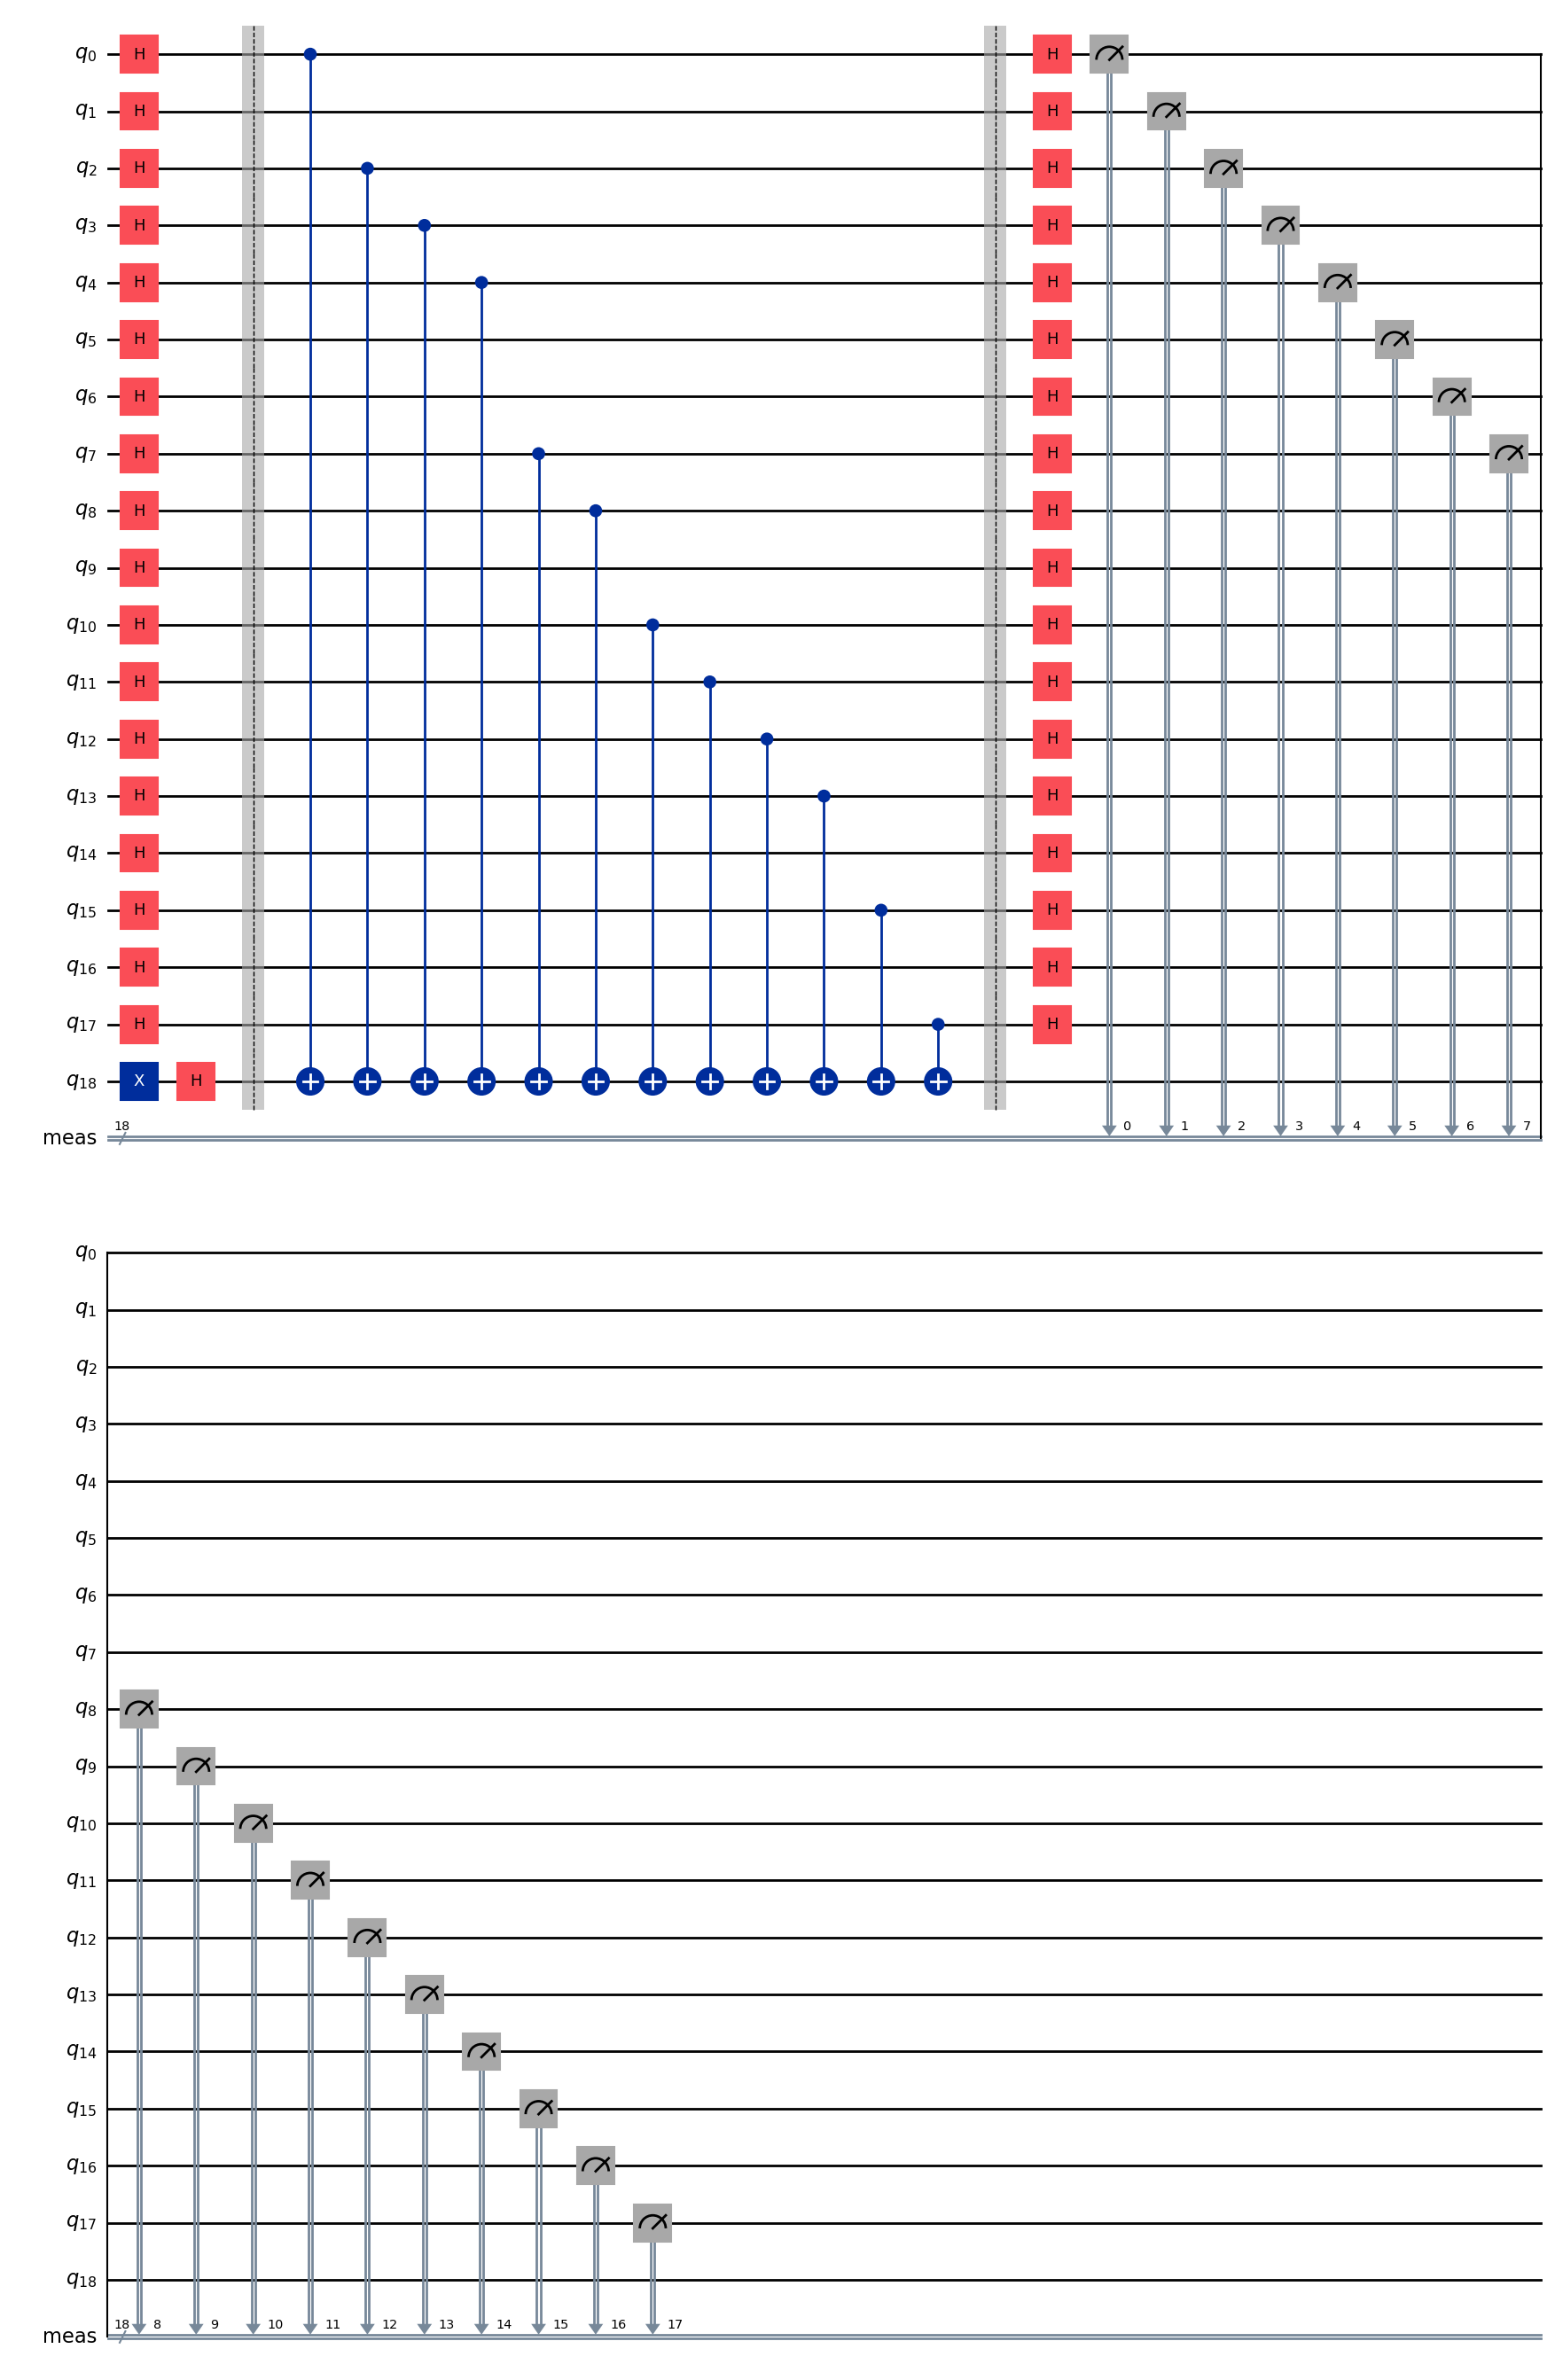

In [4]:
oracle = bernstein_vazirani_oracle("101011110110011101")
qc = get_bernstein_vazirani_circuit(oracle)
qc.draw("mpl")

## Obtener la profundidad y el factor unitario

### Profundidad

In [5]:
print(f"La profundidad del circuito es {qc.depth()}")

La profundidad del circuito es 16


A continuación, analizamos por qué la profundidad es 10:

1. Primero se aplican de manera paralela puertas `H` sobre los qubits $q_0...q_9$ y la puerta `X` sobre el qubit $q_{10}$. Tras este punto la **profundidad es 1**.
2. Luego se ejecuta la puerta `H` sobre el qubit $q_{10}$. Esta puerta se podría ejecutar al mismo tiempo que las siguiente puertas `CX`, pero como hemos colocado antes una barrera, primero se deben de ejecutar todas las puertas que están a la izquierda de dicha barrera. Tras este punto la **profundidad es 2**.
4. Una vez ya hemos pasado la primera barrera, se aplican 6 `CX` sobre el qubit $q_9$, las cuales, debido a que se aplican sobre el mismo qubit, no se pueden aplicar de forma paralela. Tras este punto, la **profundidad es 8**.
5. Pasada la segunda barrera, se aplican de forma paralela puertas `H` sobre los qubits $q_0...q_9$. Tras este punto, la **profundidad es 9**.
6. Por útimo, se realiza de manera simultánea una medición sobre todos los qubits excepto el último (el ancilla). Tras este punto, la **profundidad es 10**.


### Factor unitario

In [6]:
print(f"El factor unitario es {qc.num_unitary_factors()}")

El factor unitario es 7


Debido a que se produce entrelazamiento entre los qubits $q_0, q_2, q_3, q_4, q_5, q_6$ y el qubit $q_9$, todos estos 7 qubits pasan a formar parte de un mismo "grupo".

Por otro lado, los qubits $q_1, q_7, q_8$ y $q_10$, no realizan ningún tipo de entrelazamiento, por lo que cada uno de ellos forma su propio "grupo".

Por lo tanto, tenemos 5 grupos diferentes, es decir, un factor unitario de 5.

## Simular el comportamiento ideal

Utilizaremos `qiskit-aer` para realizar las simulaciones ideales.

### `Sampler`

`Sampler` se utiliza para obtener una distribución de probabilidad de los resultados de la medición.

Primero de todo, definimos una función para poder samplear un circuito cualquiera sobre un backend arbitrario.

In [7]:
def sample_circuit(
    qc: QuantumCircuit,
    backend: Backend,
    nshots: int = 1000,
    optimization_levels: Optional[list[int]] = None,
) -> None:
    sampler = Sampler(backend, options={"default_shots": nshots})

    if optimization_levels is None:
        transpiled_circuits = [transpile(qc, backend)]
    else:
        results = [
            _do_transpilation(qc, backend, optimization_level)
            for optimization_level in optimization_levels
        ]
        transpiled_circuits, transpiled_circuits_info = zip(*results)

    job = sampler.run(transpiled_circuits, shots=nshots)
    result = job.result()

    for i in range(len(transpiled_circuits)):
        counts = result[i].data.meas.get_counts()

        total_shots = sum(counts.values())
        probabilities = {k: v / total_shots for k, v in counts.items()}

        if not optimization_levels:
            title = "Defecto"
        else:
            title = optimization_levels[i]
            print(transpiled_circuits_info[i])

        display(plot_histogram(probabilities, title=f"Nivel de Optimización: {title}"))


def _do_transpilation(
    circuits: QuantumCircuit,
    backend: Backend,
    optimization_level: Optional[list[int]] = None,
) -> tuple[QuantumCircuit, str]:
    start = time()
    transpiled_qc = transpile(qc, backend, optimization_level=optimization_level)
    transpilation_time = time() - start

    transpiled_circuit_info = f"""
        Información sobre el circuito transpilado:
         > Nivel de optimización: {optimization_level}
         > Profundidad: {transpiled_qc.depth()}
         > Tiempo de transpilación: {transpilation_time:.5f}
        """

    return transpiled_qc, transpiled_circuit_info

Con dicha función ya definida, sampleamos nuestro circuito:

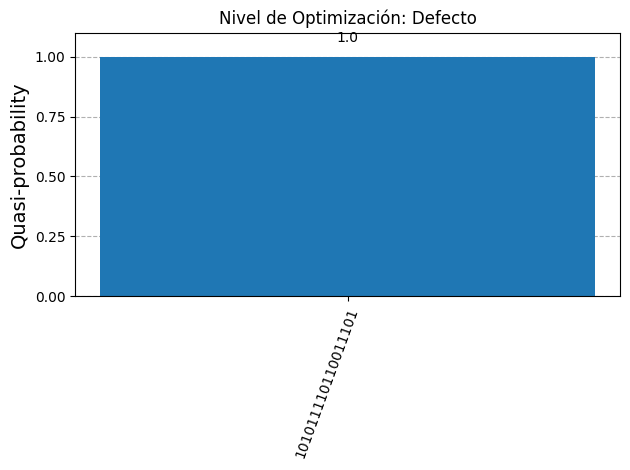

In [8]:
sample_circuit(qc, AerSimulator())

Vemos que, el resultado obtenido se corresponde con el esperado, únicamente se mide la cadena que anteriormente hemos introducido a la función para obtener el oráculo.

### `Estimator`

`Estimator` se utiliza para calcular el valor esperado de un observable.

Para el circuito que estamos utilizando, el algoritmo de Bernstein-Vazirani, no tiene sentido utilizar el `Estimator`, ya que lo que queremos es obtener los `0` y `1` de la salida para reconstruir dicha cadena. Por lo tanto `Estimator` devolvería un valor promedio que no serviría para este problema específico.

Sin embargo, en el caso de que tuviera sentido utilizar `Estimator`, deberíamos de añadir un input a mayores, el observable sobre el que queremos realizar la medición.

## Simular con un fake provider

In [ ]:
sample_circuit(qc, FakeFez())

Como podemos observar, aunque en la gran mayoría de las ocasiones obtenemos el resultado esperado, aparecen también ejecuciones en las que el resultado obtenido es diferente. Esto se debe al ruido presente en el ordenador cuántico simulado por el fake provider que hemos escogido, en este caso `IBM Fez`.

### Simular en 2 fake providers distintos

En el caso hipotético de realizar la simulación en 2 fake providers disntintos, es muy poco probable que obtengamos los mismos resultados en las 2 ejecuciones.

Esto se debe a los siguientes factores:
- Si los fake providers son diferentes, entonces cada uno utiliza un modelo de ruido distinto, motivo por el cual, dependiendo de que tan diferentes sean estos modelos de ruido, los resultados serían más o menos parecidos.
- Aún utilizando el mismo fake provider, muy probablemente no obtendríamos exactamente los mismos resultados, puesto que los ordenadores cuánticos no son 100% deterministas. Además, tenemos cierta tasa de error, pero si tenemos una tase de error de, por ejemplo, el 5% en lectura, no tenemos por qué leer mal el 5% de las veces, sino que puede variar, aunque, de media, será del 5%.

## Simular en un ordenador cuántico IBM real

Primero de todo, cargamos nuestra cuenta:

In [ ]:
load_dotenv()
ibm_key = os.getenv("IBM_KEY")
QiskitRuntimeService.save_account(token=ibm_key, overwrite=True)

Con esto, ya podemos ejecutar nuestro circuito:

qiskit_runtime_service.__init__:WARNING:2025-12-14 23:23:41,029: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-14 23:23:41,030: Using instance: open-instance, plan: open


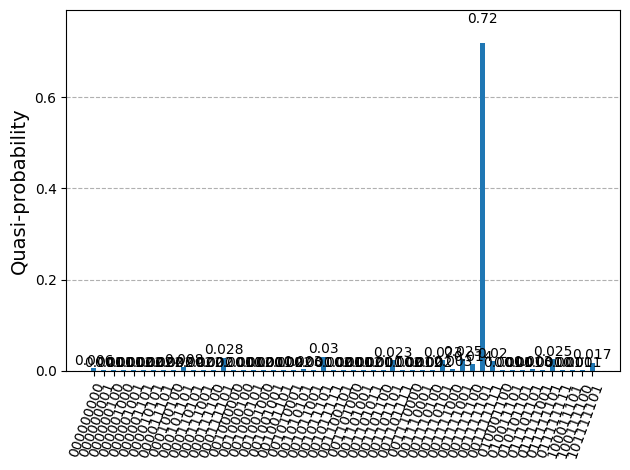

In [41]:
service = QiskitRuntimeService()
backend = service.backend("ibm_fez")
sample_circuit(qc, backend)

Como podemos observar, al igual que ocurría con el fake provider, obtenemos el resultado correcto la mayor parte de las veces, aunque, debido al ruido, en bastantes ocasiones (en torno al 25% de las veces), obtenemos resultados incorrectos.

## Ejecutar con los distintos niveles de optimización

In [ ]:
backend = FakeFez()
sample_circuit(qc, backend, optimization_levels=[0, 1, 2, 3])